In [155]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, BatchSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms as tf
from torchvision.models import vgg16, VGG, VGG16_Weights

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [143]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [144]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")    

Using device: cpu


# Create Celebs Dataset

In [145]:
available_modes = ['train', 'val', 'test']
images_path = './celebA_train_500/celebA_imgs/'
class CelebDataset(Dataset):
    def __init__(self, mode: str = 'train'):
        if mode not in available_modes:
            raise ValueError(f'Unrecognized mode: {mode}')
        df = pd.read_csv('./celebA_train_500/celebA_train_split.txt', sep=' ', names=['Image', 'Mode'])
        self.image_annos = pd.read_csv('./celebA_train_500/celebA_anno.txt', sep=' ', names=['Image', 'Person'])
        self.train_images = df[df['Mode'] == 0]['Image'].to_numpy(dtype=str)
        self.val_images = df[df['Mode'] == 1]['Image'].to_numpy(dtype=str)
        self.test_images = df[df['Mode'] == 2]['Image'].to_numpy(dtype=str)
        self._mode = mode
    
    def __len__(self):
        return len(self.get_images_depend_on_mode())
    
    def __getitem__(self, index):
        image_name = self.get_images_depend_on_mode()[index]
        image_path = images_path + image_name
        image = np.array(Image.open(image_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        transform = tf.Compose([tf.ToTensor()])
        transformed_image = transform(image)
        annotation: pd.DataFrame = self.image_annos
        person_id = annotation[annotation['Image'] == image_name]['Person'].values[0]
        return transformed_image, person_id
        
    def get_images_depend_on_mode(self) -> np.array:
        if self._mode == 'train':
            return self.train_images
        elif self._mode == 'val':
            return self.val_images
        elif self._mode == 'test':
            return self.test_images
        else:
            raise ValueError(f'Unrecognized mode: {self._mode}')
        
        

In [146]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

# Let's look at cropped images from celeb dataset

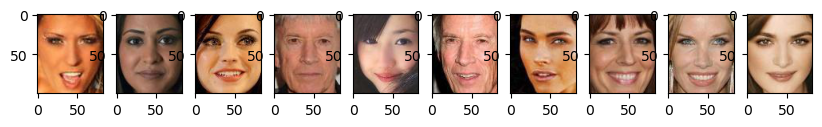

In [147]:
import random

nrows, ncols = 1,  10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
ax = ax.flatten()
to_pil = tf.ToPILImage()
for i in range(nrows * ncols):
    rand_index = random.randint(0, len(train_dataset) - 1)
    image_tensor = train_dataset.__getitem__(rand_index)[0]
    pil_image = to_pil(image_tensor)
    ax[i].imshow(pil_image)



# # Plot more images
# torch.manual_seed(42)
# fig = plt.figure(figsize=(9, 9))
# rows, cols = 4, 4
# for i in range(1, rows * cols + 1):
#     random_idx = torch.randint(0, len(train_data), size=[1]).item()
#     img, label = train_data[random_idx]
#     fig.add_subplot(rows, cols, i)
#     plt.imshow(img.squeeze(), cmap="gray")
#     plt.title(class_names[label])
#     plt.axis(False);


In [148]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

## Train Loop

Let's describe a train function which we well user for all experiments with face recognition.

In [149]:
# def eval_accuracy(model: Module, dataloader: DataLoader):
#     model.eval()
#     timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
#     summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
#     for _, (images, labels) in enumerate(dataloader):
#         with torch.no_grad():
#             outputs = model(images)
#             
        

In [150]:
def train(
        train_dataloader: DataLoader, 
        val_dataloader: DataLoader,
        criterion,
        optimizer: Optimizer,
        model: Module, 
        epochs: int = 50):
    
    model.to(device=device)
    
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
    
    print(f'Starting training for {epochs}')
    
    for epoch in trange(epochs):
        for _, data in enumerate(train_dataloader):
            model.train(mode=True)
            
            images, labels = data
            images_to_device = images.to(device)
            
            output = model(images_to_device)
            loss: Tensor = criterion(output, labels)
            
            # calculate accuracy
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.inference_mode():
            for _, val_data in enumerate(val_dataloader):
                val_images, val_labels = val_data
                val_images_to_device = val_images.to(device)
                val_predictions = model(val_images_to_device)
                val_loss: Tensor = criterion(val_predictions, val_labels)
                
        if epochs % 10 == 0:
            print(f'Epoch: {epoch} | Train loss {loss} | Validation loss {val_loss}.')
        
        summary_writer.flush()     
        
    print(f'Finished training for {epochs}. Set model in eval mode.')      
    model.eval()    
            


# VGG16 + Cross-Entropy Loss

Let's use pretrained VGG16 network. Here I change fully-connected layers and freeze convolutional layers to relearn the network to recognize faces. 

In [151]:
model: VGG = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze feature parameters in the "feature" section of the model, because we want to train only classifier
for param in model.features.parameters():
    param.requires_grad = False

# Let's assign a brand-new classifier to our model. We will train it during train procedure
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=128),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=500)
)

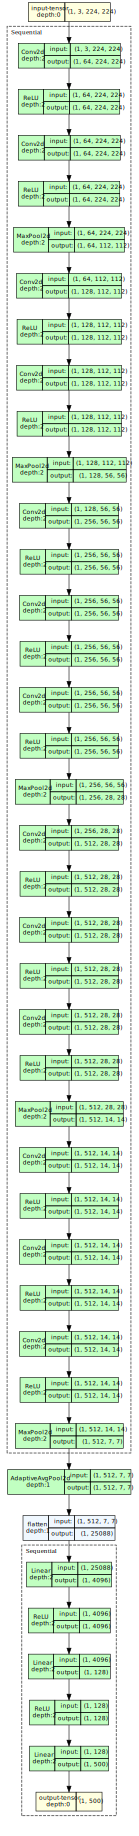

In [152]:
# Let's look at network architecture
from torchview import draw_graph
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

## Loss Function and Optimizer

In [153]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Run Train Loop

In [ ]:
train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataset,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

Starting training for 50


  0%|          | 0/50 [00:00<?, ?it/s]